### Imports

Perform necessary imports and preparation

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
import numpy as np

from torchviz import make_dot
from tqdm import tqdm

import matplotlib.pyplot as plt

from skindataset import SkinDataset
from skindiffuser import NoiseScheduler, SkinUnet
from util import HParams

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Notebook is running on device: {device}')

Notebook is running on device: cuda


For easier tuning and experimentation regarding hyperparameters, we outsource them into a json file. The following utility class loads the values and makes the accessible to the code

In [2]:
hparams = HParams()
hparams

{'T': 600, 'batch_size': 256, 'learning_rate': 0.001, 'epochs': 128}

### Load Data

We use an extensive dataset of +900'000 minecraft skins to train our diffusion model. The data was sourced from

https://www.kaggle.com/datasets/sha2048/minecraft-skin-dataset/code

and underlies the CC0: Public Domain License.

Load the dataset and create a dataloader. We limit the number of loaded samples to $400'000$ for now

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Loaded dataset of 945061 samples with an 80/20 train test split (756049 train, 189012 test) training set has 2953 batches and test set has 738 batches
Each batch contains 256 images of size 64x64


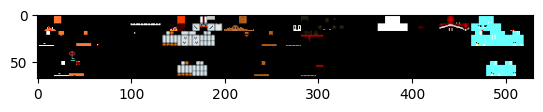

In [3]:
train_data, test_data = torch.utils.data.random_split(SkinDataset(), [0.8, 0.2])

train_loader = DataLoader(train_data,
                          batch_size=hparams.data['batch_size'],
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=hparams.data['batch_size'],
                         shuffle=True,
                         drop_last=True)

print(f"Loaded dataset of {len(train_data) + len(test_data)} samples \
with an 80/20 train test split ({len(train_data)} train, {len(test_data)} test) \
training set has {len(train_loader)} batches and test set has {len(test_loader)} batches")

img_batch = next(iter(train_loader))
print(f"Each batch contains {img_batch.size(0)} images of size {img_batch.size(2)}x{img_batch.size(3)}")

def imshow_grid(batch, num_images=8):
    if batch.size(0) < num_images:
        img_grid = torchvision.utils.make_grid(batch)
    else:
        img_grid = torchvision.utils.make_grid(batch[:num_images])
    npimg = img_grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow_grid(img_batch, 8)


### Forward process

The forward diffusion process uses a basic noise scheduler

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6708946..3.8888724].


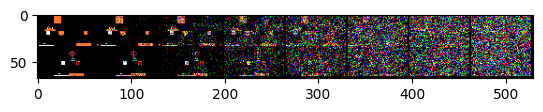

In [4]:
NUM_IMGS = 8
T = hparams.data['T']

ns = NoiseScheduler(T)
stepsize = int(T/NUM_IMGS)
out = torch.empty((NUM_IMGS+1, 3, 64, 64))
idx = 0
for i in range(0, T, stepsize):
    t = torch.tensor([i]).type(torch.int64)
    image, noise = ns.forward_sample(img_batch[0], t)
    out[idx] = image
    idx += 1

imshow_grid(out, NUM_IMGS)

### Backward process

The backward process is a simple Unet architecture. For details on implementation consult ```skindiffuser.py```

In [5]:
unet = SkinUnet()
print(f"Num params: {sum(p.numel() for p in unet.parameters())}")
print(unet)

# Visualize the model
# NOTE: Visualization is too large to render in Jupyter. PNG file is provided in the repo.
#make_dot(unet(img_batch, torch.randint(0, 200, (256,)).long()), params=dict(list(unet.named_parameters()))).render("unet", format="png")

Num params: 106720579
SkinUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=64, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (residual_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (down): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Block(
      (time_mlp): Linear(in_features=64, out_features=256, bias=True)
      (con

### Training loop

We define a simple l1 loss on the predicted noise at time step $t$

In [6]:
def training_loss(model, x_0, t):
    x_noisy, noise = ns.forward_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [7]:
@torch.no_grad()
def sample_timestep(x, t, unet):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = NoiseScheduler.get_index_from_list(ns.betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = NoiseScheduler.get_index_from_list(
        ns.sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = NoiseScheduler.get_index_from_list(ns.sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * unet(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = NoiseScheduler.get_index_from_list(ns.posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    

The main training loop. We attach the unet to the training device and train it under a simple adam optimizer

In [8]:
unet.to(device)
optimizer = Adam(unet.parameters(), lr=hparams.data['learning_rate'])
epochs = hparams.data['epochs']

train_losses = []

# We use mixed precision training to speed up training
# remove these lines if your architecture does not support it
from torch.amp import autocast, GradScaler
scaler = GradScaler()
#---------------------------------

for epoch in range(epochs):

    # Wrap train_loader with tqdm for the inner loop
    progress_bar = tqdm(train_loader, desc=f"\033[96mTraining Epoch {epoch}\033[0m", leave=False)

    # ---------------
    # TRAINING LOOP
    # ---------------
    unet.train()
    train_loss = 0
    for step, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        
        t = torch.randint(0, hparams.data["T"], # Sample uniformly from [0, T)
                          (hparams.data["batch_size"],), # of shape (batch_size,)
                          device=device).long()
        
        with autocast(device_type=device, enabled=True):
            train_loss_batch = training_loss(unet, batch, t)

        scaler.scale(train_loss_batch).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += train_loss_batch.item()

        # Update tqdm bar with the current loss
        progress_bar.set_postfix(loss=train_loss_batch.item())


    # Save model checkpoint
    if epoch % 10 == 0 or epoch == 127:
        torch.save(unet.state_dict(), f"checkpoints/unet_epoch_{epoch}.pt")
            

KeyboardInterrupt: 

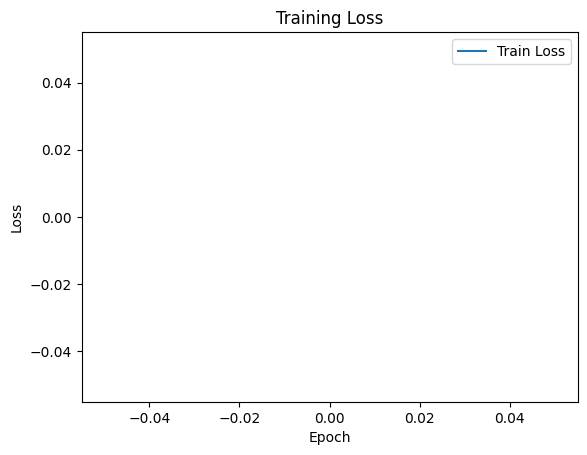

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

### Inference test

To infer new images with the trained model, we generate random noise and iteratively denoise it through the unet

In [10]:
device = 'cuda'

In [20]:
model = SkinUnet()
model.load_state_dict(torch.load("checkpoints/unet_epoch_125.pt"))
model.to(device)
model.eval()

SkinUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.160318..2.3962827].


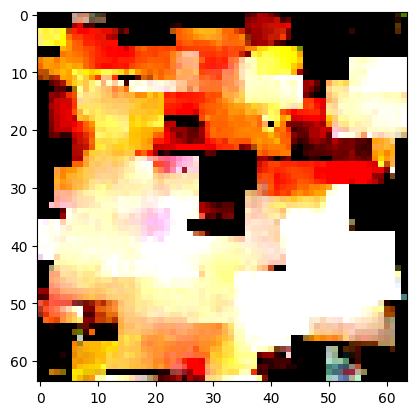

In [ ]:
# Sample noise
img = torch.randn((1, 3, 64, 64), device=device)

for i in range(hparams.data['T'])[::-1]:
    t = torch.full((1,), i, device=device).long()
    img = sample_timestep(img, torch.tensor([i]).long().to(device), model)

npimg = img[0].cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
